# Geo-Spatial analysis



### Geospatial analysis is the gathering, display, and manipulation of imagery, GPS, satellite photography and historical data, described explicitly in terms of geographic coordinates or implicitly, in terms of a street address, postal code, or forest stand identifier as they are applied to geographic models.

# We will be using Folium for the analysis. 

### Folium makes it easy to visualize data that’s been manipulated in Python on an interactive Leaflet map. It enables both the binding of data to a map for choropleth visualizations as well as passing Vincent/Vega visualizations as markers on the map.

### The library has a number of built-in tilesets from OpenStreetMap, MapQuest Open, MapQuest Open Aerial, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. Folium supports both GeoJSON and TopoJSON overlays, as well as the binding of data to those overlays to create choropleth maps with color-brewer color schemes.

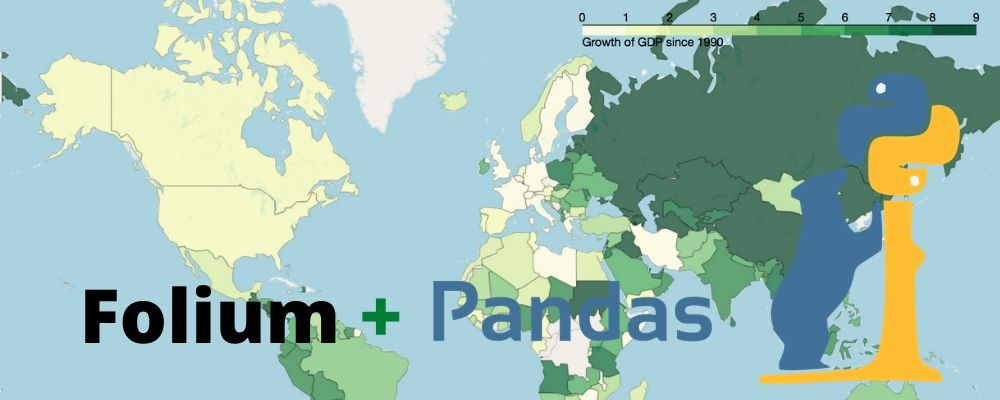

# Ques. What are we going to do here?? 

### We are going to use the data given to find -- <br> 1. Regions affected - on the bases of area affected.
### 2. Highlight regions on the bases of --- <br>a) No. of Confirmed cases <br>b) No. of Deaths occured <br> c) No. of Cured cases and <br>d) No. of Active cases. 


# Finally , If you like it do comment and upvote . Thank you!!!🙏

## Importing Libraries 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Ploting and visualisations 
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px 
from plotly.offline import download_plotlyjs,init_notebook_mode, iplot
import plotly.tools as tls 
import plotly.figure_factory as ff 
py.init_notebook_mode(connected=True)
# ----------------------- #


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
confirmed_case = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
confirmed_case_us = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_confirmed_US.csv')
death_case = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths_US.csv')
covid_19_recovered = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv')
covid_19_data = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv')
covid_19_deaths = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv')
COVID19_line_list_data = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv')
COVID19_open_line_list = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv')

# We will only use the covid_19.csv as it is a compliation of the other dataset. 

In [ ]:
display(covid_19_data.info(),covid_19_data.head())

In [ ]:
## checking if any null values in the dataset
covid_19_data.isnull().sum()

### Its evident that column -- 'Province/State' has some null values that has to be filled. 
### But before it lets check what percentage of null data are we talking about..

In [ ]:
def missing_value(covid_19_data):
    null_data = pd.DataFrame(((covid_19_data.isnull().sum())/len(covid_19_data['Confirmed']))*100,columns = ['percentage'])
    null_data = null_data.round(2)
    trace = go.Bar(x=null_data.index,y=null_data['percentage'],opacity=0.5,text = null_data['percentage'],textposition = 'auto', marker=dict(color = 'turquoise',line=dict(color= 'green',width=1.5)))
    
    layout = dict(title='Percentage of null data in dataset')
    
    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)

In [ ]:
missing_value(covid_19_data)

### We have a column(Province/State) with 35.64% null values thus we cannot drop it and have to fill the missing values

# Fill missing values 

### We are going to fill missing names with 'unknown' region.

In [ ]:
covid_19_data['Province/State'] = covid_19_data['Province/State'].fillna('Unknown')

In [ ]:
display(covid_19_data.isnull().sum(),covid_19_data.head())

## Hey, now that we have filled missing values we can tune some of featuers like the names of countries and few columns to our requirement..

# Feature Engineering 

## 1.Changing Data Type -- 

### The data looks better however we can also convert Data Type for "Confirmed","Deaths" and "Recovered" columns to int as they don't happen in fractions..

In [ ]:
covid_19_data[["Confirmed","Deaths","Recovered"]] = covid_19_data[["Confirmed","Deaths","Recovered"]].astype(int)

## 2. Change name of few countries.. 

### we are going to change name of 'Mainland China' to 'China'.  

In [ ]:
covid_19_data['Country/Region'] = covid_19_data['Country/Region'].replace('Mainland China','China')

## 3. Active case column 

### Some countries may have a lot of confirmed cases but have also have many cured people.. 

In [ ]:
covid_19_data['Active'] = covid_19_data['Confirmed'] - (covid_19_data['Deaths']+covid_19_data['Recovered']) 

# Affected countries.. 

In [ ]:
# Used just to see all the rows for critical analysis. 
# pd.set_option("display.max.rows", None)

In [ ]:
## covid_19_data[covid_19_data['ObservationDate'] == covid_19_data['ObservationDate'].max()] to find the latest data on dases of the day 
## We then sum the latest day data and group them by 'Countries'

df1 = covid_19_data[covid_19_data['ObservationDate'] == covid_19_data['ObservationDate'].max()].groupby(["Country/Region"])[["Confirmed","Active","Recovered","Deaths"]].sum().reset_index()

In [ ]:
## We are adding the latitude and longitude with df1 table.
df2 = confirmed_case[['Country/Region','Lat','Long']].reset_index()

## We had multiple loction for the same country so we removed the duplicate values. 
df2 = df2.drop_duplicates(subset = ["Country/Region"])

In [ ]:
# We merged the two dataframes to have location of the countries also .. 
merge_1_2 = pd.merge(df1,df2, on=['Country/Region'], how='inner')

## Droping Column index as not required
merge_1_2 = merge_1_2.drop(columns=['index'])

display(merge_1_2,merge_1_2.info())

In [ ]:
## Our tool for ploting these beautiful maps..
import folium

In [ ]:
## We need coordinates to figure out where we can place our pointers 
locations = merge_1_2[['Lat', 'Long']]
locationlist = locations.values.tolist()

## 1. 'Areas affected' -- using Folium Marker Clusters –
### Marker clusters can be a good way to simply a map containing many markers. When the map is zoomed out nearby markers are combined together into a cluster, which is separated out when the map zoom level is closer.

### 1. Let's see which all countries are affected and then evaluate which continents where affected on bases of '*Areas affected*'. 

In [ ]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[20.5937, 0], tiles='CartoDB dark_matter', zoom_start=2)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=merge_1_2['Country/Region'][point]).add_to(marker_cluster)
map2

####  It's clearly evident that Africa is the most affected region in terms of '**Area**' affected, followed by Europian Nation and South America and so on..

## 2. If we want to check individual regions we can simply use Marker..

In [ ]:
map = folium.Map(location= [20.5937, 0],tiles='CartoDB dark_matter', zoom_start=2)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=merge_1_2['Country/Region'][point]).add_to(map)
map

## We can clearly see that many African and Europian regions are affected most.

## + Distribution on the bases of -- 'Confirmed Cases'

In [ ]:
# Make an empty map
m = folium.Map(location=[20,0], tiles="CartoDB dark_matter", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(merge_1_2)):
    folium.Circle(
      location=locationlist[i],
      popup = (
        "<strong>Country/Region:</strong> {Country}</br>"
        "<strong>Confirmed case:</strong> {Confirmed}<br>"
    ).format(Country=str(merge_1_2.iloc[i]['Country/Region']), Confirmed=str(merge_1_2.iloc[i]['Confirmed'])),
      radius=merge_1_2.iloc[i]['Confirmed']/2.5,
      color='darkorange',
      fill=True,
      fill_color='darkorange'
   ).add_to(m)
 
# Save it as html
#m.save('mymap.html')
m

## Here we can see which country has more number of 'Confirmed cases' by seeing the size of the 'Circle'. 
## America has the highest number of 'Confirmed' cases followed by Brazil,India and Russia.

## Top 10  countries affected by Covid-19 

In [ ]:
def bar_plot(merge_1_2,var):
    Countries_data = merge_1_2.nlargest(10,[var])
    #Countries_data['per'] = (Countries_data[var]/sum(Countries_data[var]))*100
    trace = go.Bar(y=Countries_data[var],x=Countries_data['Country/Region'],opacity=0.5,
                   text = Countries_data[var],textposition = 'auto',
                   marker_color =  px.colors.qualitative.Bold
                   )
    
    layout = dict(title='Top 10 countries with highest {} cases'.format(var))
    
    fig = dict(data=[trace], layout=layout)
    py.iplot(fig)

In [ ]:
bar_plot(merge_1_2,'Confirmed')

## Again we have confirmed that America has the highest number of 'Confirmed' cases followed by Brazil,India and Russia.

## + Distribution on the bases of -- 'Active Cases'

In [ ]:
# Make an empty map
m = folium.Map(location=[20,0], tiles="CartoDB dark_matter", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(merge_1_2)):
    folium.Circle(
      location=locationlist[i],
      popup = (
        "<strong>Country/Region:</strong> {Country}</br>"
        "<strong>Active case:</strong> {Active}<br>"
    ).format(Country=str(merge_1_2.iloc[i]['Country/Region']), Active=str(merge_1_2.iloc[i]['Active'])),
      radius=merge_1_2.iloc[i]['Active']/2.5,
      color='#9ACD32',
      fill=True,
      fill_color='#9ACD32'
   ).add_to(m)
 
# Save it as html
#m.save('mymap.html')
m

## Again country with higher number of 'Active cases' has bigger 'Circler' size.
## America has the highest number of 'Active' cases followed by Brazil, India and Russia.

In [ ]:
bar_plot(merge_1_2,'Active')

## America has the highest number of 'Active' cases followed by Brazil,India and Russia. However except US other countries have comparatively less number of 'Active' case in comparison with 'Confirmed' cases.  

## + Distribution on the bases of -- 'Death Cases'

In [ ]:
# Make an empty map
m = folium.Map(location=[20,0], tiles="CartoDB dark_matter", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(merge_1_2)):
    folium.Circle(
      location=locationlist[i],
      popup = (
        "<strong>Country/Region:</strong> {Country}</br>"
        "<strong>Death case:</strong> {Deaths}<br>"
    ).format(Country=str(merge_1_2.iloc[i]['Country/Region']), Deaths=str(merge_1_2.iloc[i]['Deaths'])),
      radius=merge_1_2.iloc[i]['Deaths']/.125,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
# Save it as html
#m.save('mymap.html')
m

## Again country with higher number of 'Death cases' has bigger 'Circler' size.
## Sadly again, America has the highest number of 'Death' cases followed by Brazil,Italy and Spain.

In [ ]:
bar_plot(merge_1_2,'Deaths')

## Note: Interestingly though India and Russia was among the top 4 countries in other catogeries yet they has managed to keep the number of casualities very low.

## + Distribution on the bases of -- 'Recovered patient'

In [ ]:
# Make an empty map
m = folium.Map(location=[20,0], tiles="CartoDB dark_matter", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(merge_1_2)):
    folium.Circle(
      location=locationlist[i],
      popup = (
        "<strong>Country/Region:</strong> {Country}</br>"
        "<strong>Recovered patient:</strong> {Recovered}<br>"
    ).format(Country=str(merge_1_2.iloc[i]['Country/Region']), Recovered=str(merge_1_2.iloc[i]['Recovered'])),
      radius=merge_1_2.iloc[i]['Recovered']/1,
      color='#028ACA',
      fill=True,
      fill_color='#028ACA'
   ).add_to(m)
 
# Save it as html
#m.save('mymap.html')
m

## Again country with higher number of 'Recovery rate' has bigger 'Circler' size.
## Brazil has the highest number of 'Recovery rate' followed by America,Russia & India.

In [ ]:
bar_plot(merge_1_2,'Recovered')

## All countries are doing good as the recovery is not stoping and is more than Active case in some countries. 

# So with this we come to the end. I have discused on only out of so many ways one can use these tools to perform the analysis. Well keep on updating the notebook with new maps also. 

# Hope You will find it useful and interesting. 

# Please do comment and upvote the same. Thank You!!🙏🙏